In [2]:
import pickle 
import sys 
import os 
import matplotlib.pyplot as plt 
import numpy as np 
from glob import glob 
sys.path.append(os.path.abspath('../checkpoints'))
sys.path.append(os.path.abspath('../src'))
import numpy as np
from scipy import stats
import pandas as pd
import random 
from ea import EA
from ea import Material 
from ea import Grain
from utils import get_densities, read_particle_data

In [3]:
seeds = [30,31,32,33,34,35,36]
gen = 99 
eval_method = 'tri_obj'
gate_1 = "XOR"
gate_2 = "AND"
period1 = 0.0666
period2 = 0.05

In [4]:
seed_id_map = {}
for seed in seeds:
    seed_id_map[seed] = []

# best_material_ids = pd.read_csv(f"{eval_method}_eval_{gate_1}_{gate_2}.csv")

In [7]:
for seed in seeds:
    # if seed == 9: continue
    checkpoint_file = f'../final_checkpoints/{eval_method}_eval_run{seed}_period{period1}_period{period2}_{gen}gens_{gate_1}_{gate_2}.p'
                        #   /checkpoints/seq_eval_run0_period0.0666_period0.05_99gens_AND_AND.p
    # Load rng state and afpo state
    with open(checkpoint_file, 'rb') as f:
        EA, rng_state, np_rng_state = pickle.load(f)
    os.makedirs(f"../dumps/period{period1}_period{period2}", exist_ok=True)
    # best_org_this_seed = best_material_ids.iloc[seed]['org_id']
    for org in EA.population: 
        # if org.id == best_org_this_seed:
        # org.replay_material()
        seed_id_map[seed].append(org.id)
    # for material in EA.population: 
        # material.replay_material()

In [4]:
# for file in glob(f"{eval_method}_eval_materials/*AND_AND*"):
#     # 'dump 1  all  custom 5 ${method}_eval_materials/dump.${method}_eval_seed${seed}_id${id}_${case}_XOR_AND id x y z radius fx fy fz mass'
#     # print(file.split("id")[1].split("_")[0] )
#     if file.split("id")[1].split("_")[0] not in best_material_ids: 
#         os.system(f"rm {file}")

In [8]:
seed_id_map

{30: [7112,
  10738,
  11201,
  13621,
  17418,
  17854,
  18019,
  18313,
  18354,
  18380,
  18445,
  18594,
  18634,
  18759,
  18793,
  18850,
  18884,
  18893,
  18998,
  19040,
  19061,
  19105,
  19113,
  19119,
  19138,
  19150,
  19185,
  19229,
  19237,
  19291,
  19312,
  19352,
  19353,
  19389,
  19408,
  19413,
  19433,
  19435,
  19441,
  19448,
  19455,
  19475,
  19491,
  19499,
  19510,
  19515,
  19517,
  19524,
  19530,
  19534,
  19538,
  19542,
  19543,
  19565,
  19577,
  19591,
  19600,
  19608,
  19627,
  19633,
  19638,
  19656,
  19660,
  19661,
  19663,
  19669,
  19670,
  19671,
  19676,
  19685,
  19687,
  19690,
  19695,
  19699,
  19704,
  19709,
  19726,
  19727,
  19729,
  19732,
  19735,
  19738,
  19741,
  19743,
  19750,
  19751,
  19753,
  19754,
  19755,
  19757,
  19759,
  19760,
  19766,
  19769,
  19770,
  19772,
  19786,
  19793,
  19796,
  19797],
 31: [5455,
  10459,
  11820,
  13143,
  15928,
  16848,
  17274,
  17609,
  17935,
  18167,
  1

In [9]:
def get_1_threshold(f_peak_map, gate1, gate2):
    '''Returns the power for each signal that should be '1'
    '''
    threshold = 100
    all_thresh = []
    if gate1 == "AND": peak_cases1 = ['11']
    if gate1 == "XOR": peak_cases1 = ['01', '10']
    if gate2 == "AND": peak_cases2 = ['11']
    if gate2 == "XOR": peak_cases2 = ['01', '10']
    for input_case_pair, power in f_peak_map.items():
        if input_case_pair[:2] in peak_cases1:
            all_thresh.append(power[0])
            if power[0] < threshold:
                threshold = power[0]
        if input_case_pair[2:] in peak_cases2:
            all_thresh.append(power[1])
            if power[1] < threshold:
                threshold = power[1]
    return threshold, all_thresh


def get_0_threshold(f_peak_map, gate1, gate2):
    '''Returns the power for each signal that should be '0'
    '''
    threshold = 100
    all_thresh = []
    if gate1 == "AND": peak_cases1 = ['11']
    if gate1 == "XOR": peak_cases1 = ['01', '10']
    if gate2 == "AND": peak_cases2 = ['11']
    if gate2 == "XOR": peak_cases2 = ['01', '10']
    for k, v in f_peak_map.items():
        if k[:2] not in peak_cases1:
            all_thresh.append(v[0])
            if v[0] < threshold:
                threshold = v[0]
        if  k[2:] not in peak_cases2:
            all_thresh.append(v[1])
            if v[1] < threshold:
                threshold = v[1]
    return threshold, all_thresh



def get_case_correct_dict(threshold, f_peak_map, gate_1, gate_2):
    correct_poly_map = {}
    # if gate1 == "AND": peak_cases1 = ['11']
    # if gate1 == "XOR": peak_cases1 = ['01', '10']
    # if gate2 == "AND": peak_cases2 = ['11']
    # if gate2 == "XOR": peak_cases2 = ['01', '10']
    for k, v in f_peak_map.items():
        case1 = k[:2]
        case2 = k[2:]
        f1_response = False
        f2_response = False
        if gate_1 == "XOR":
            if case1 == "01":
                if v[0] >= threshold:
                    f1_response = True 
                else:
                    f1_response = False
            if case1 ==  '10':
                if v[0] >= threshold:
                    f1_response = True 
                else:
                    f1_response = False
            if case1 == "00":
                if v[0] < threshold:
                    f1_response = True 
                else: 
                    f1_response = False 
            if case1 == "11":
                if v[0] < threshold:
                    f1_response = True 
                else: 
                    f1_response = False 
        if gate_1 == "AND":    
            if case1 == "11" and v[0] >= threshold:
                f1_response = True
            elif case1 != "11" and v[0] <= threshold:
                f1_response = True


        if case2 == "11" and v[1] >= threshold:
            f2_response = True
        elif case2 != "11" and v[1] <= threshold:
            f2_response = True
        correct_poly_map[k] = f1_response and f2_response
    return correct_poly_map


30
0.07189311482532779 thresh
12 30 7112
30
0.08742412992297134 thresh
12 30 10738
30
0.07353832455886265 thresh
8 30 11201
30
0.09236740207150973 thresh
12 30 13621
30
0.08261412927774424 thresh
13 30 17418
30
0.07676651139544083 thresh
12 30 17854
30
0.08160500852023539 thresh
13 30 18019
30
0.053571121398138875 thresh
7 30 18313
30
0.07730158338009285 thresh
12 30 18354
30
0.07777987248029448 thresh
13 30 18380
30
0.0437507352925097 thresh
7 30 18445
30
0.0388536610982749 thresh
7 30 18594
30
0.04707774468100455 thresh
7 30 18634
30
0.04041540906131093 thresh
6 30 18759
30
0.07802552014915529 thresh
13 30 18793
30
0.0542161718206912 thresh
15 30 18850
31
0.11478122360435929 thresh
15 31 5455
32
0.06415970659849432 thresh
13 32 9133
32
0.06319450464259985 thresh
15 32 11205
33
0.02696063972213494 thresh
15 33 12097
34
0.09816429138642044 thresh
15 34 6835
35
0.09236702357800913 thresh
15 35 9001
36
0.062016365101837494 thresh
15 36 7360


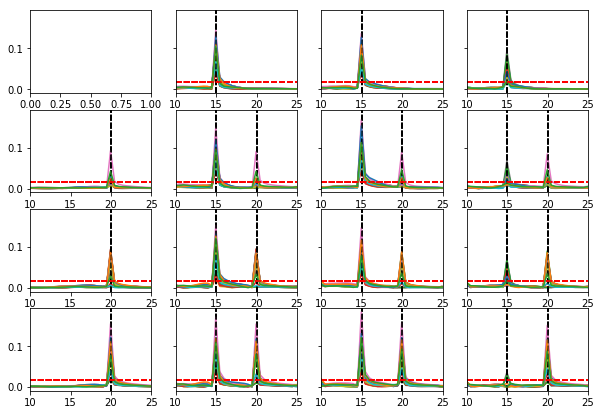

In [10]:

file_endings_mixed = []
for case_f1 in ["00", "01", "10", "11"]:
    for case_f2 in ["00", "01", "10", "11"]:
        file_endings_mixed.append(case_f1+case_f2)
file_endings_mixed = file_endings_mixed[1:]
best_thresh_result = []
correct_cases = {}
seed_org_dict = {}

for f in file_endings_mixed: 
    correct_cases[f] = 0 
for seed in seeds:#range(30):
    seed_org_dict[seed] = []
fig, ax = plt.subplots(4, 4, figsize=(10, 7), sharey=True)
f1_colmap = {"00":0, "01":1, "10":2, "11":3}
f2_rowmap = {"00":0, "01":1, "10":2, "11":3}
for seed in seeds:#seeds:#$range(30):
    perf_found = False
    for id in seed_id_map[seed]:
        if perf_found: break
        print(seed)
        try:
            particle_data_mixed = {file_ending: read_particle_data(f'{eval_method}_eval_materials/dump.{eval_method}_eval_seed{seed}_id{id}_{file_ending}_{gate_1}_{gate_2}') for file_ending in file_endings_mixed}
        except:
            continue
        #     file_ending='0101'
        #     print(f'{eval_method}_eval_materials/dump.{eval_method}_eval_seed{seed}_id{id}_{file_ending}_{gate_1}_{gate_2}')
        f_peak_map = {}
        
        for case_index,case in enumerate(file_endings_mixed):
            loc_data = []
            for point_tuple in particle_data_mixed[case][23]:
                loc_data.append(point_tuple[0])
            try:
                loc_data = np.array(loc_data) - np.mean(loc_data)
            
                time_data = np.linspace(0, 1, len(loc_data))
                freq_signal = np.fft.rfft(loc_data)
                frequencies = np.fft.rfftfreq(len(time_data), 0.005)
                freq_signal = np.abs(freq_signal)
                f1 = case[:2]
                f2 = case[2:]
                df1, df2 = 15,20
                peak_at_f1 = freq_signal[np.abs(frequencies - df1).argmin()]
                peak_at_f2 = freq_signal[np.abs(frequencies - df2).argmin()]
                f_peak_map[case] = (peak_at_f1, peak_at_f2)
            except: break
            ax[f2_rowmap[f2],f1_colmap[f1]].plot(frequencies, np.abs(freq_signal))
            if "1" in f2:
                ax[f2_rowmap[f2],f1_colmap[f1]].axvline(x=df2,color='k',linestyle='--', alpha=0.3)
            if "1" in f1:
                ax[f2_rowmap[f2],f1_colmap[f1]].axvline(x=df1,color='k',linestyle='--', alpha=0.3)
            ax[f2_rowmap[f2],f1_colmap[f1]].axhline(y=0.01693036162327329 ,color='red',linestyle='--', alpha=0.99)
            
            ax[f2_rowmap[f2],f1_colmap[f1]].set_xlim(10,25)
            # ax[f2_rowmap[f2],f1_colmap[f1]].plot(loc_data)



        threshold,all_thresh_min = get_0_threshold(f_peak_map,gate_1, gate_2)
        threshold_max,all_thresh_max = get_1_threshold(f_peak_map,gate_1, gate_2)

        thresh = sum([max(all_thresh_min), min(all_thresh_max)])/2
        sum_cases_correct = []
        print(thresh, "thresh")
        case_correct_map = get_case_correct_dict(thresh, f_peak_map,gate_1, gate_2)

        for k, v in case_correct_map.items():
            # print(k)
            correct_cases[k]+=v
        sum_cases_correct.append(sum(case_correct_map.values()))

        print(max(sum_cases_correct), seed, id)

        seed_org_dict[seed].append((max(sum_cases_correct), id))
        if max(sum_cases_correct) == 15: 
            perf_found = True

In [11]:
seed_org_dict

{30: [(12, 7112),
  (12, 10738),
  (8, 11201),
  (12, 13621),
  (13, 17418),
  (12, 17854),
  (13, 18019),
  (7, 18313),
  (12, 18354),
  (13, 18380),
  (7, 18445),
  (7, 18594),
  (7, 18634),
  (6, 18759),
  (13, 18793),
  (15, 18850)],
 31: [(15, 5455)],
 32: [(13, 9133), (15, 11205)],
 33: [(15, 12097)],
 34: [(15, 6835)],
 35: [(15, 9001)],
 36: [(15, 7360)]}

In [19]:
f = open(f"{eval_method}_eval_XOR_AND.csv",'a')
# f.write(f"seed,independence,org_id,gate_1,gate_2\n")

In [9]:
for k, v in seed_org_dict.items():
    # if k is 9: continue
    max_val = max(v)
    f.write(f"{k},{max_val[0]},{max_val[1]},{gate_1},{gate_2}\n")
f.close()
